## LSTM 사용 Text 분류 모델 구현

: Keras의 Embedding,LSTM,Dropout 계층 사용

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

## spam and ham 분류 데이터

In [17]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)
print(df['v2'][0], df['v1'][0])
df.head(20)


(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [18]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1, inplace = True)

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of ham and spam messages')

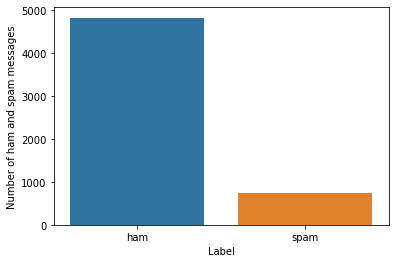

In [19]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of ham and spam messages')


In [20]:
X, Y = df.v2, df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y. reshape(-1,1)

### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [64]:
# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3)

In [65]:
max_words = 1000# D, input_dim
max_len = 150# T, sequence length : 한문장 길이, 데이터셋 길이

tok = Tokenizer(num_words = max_words)

tok.fit_on_texts(x_train)

sequences = tok.texts_to_sequences(x_train)

sequences[:4] # 길이가 서로 다름

[[51, 387, 89, 372],
 [1, 16, 2, 101, 780, 37, 8, 161],
 [1,
  187,
  11,
  2,
  7,
  1,
  130,
  2,
  28,
  13,
  4,
  296,
  1,
  106,
  34,
  3,
  22,
  537,
  15,
  28,
  4,
  20,
  432,
  167,
  203,
  113,
  388,
  9,
  73,
  10,
  5],
 [462, 3, 409, 3, 22, 24, 410]]

In [66]:
# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150), 2차원 행렬
word_to_index = tok.word_index
# print(word_to_index)

vocab_size = len(word_to_index)
print(vocab_size)

sequences_matrix

(3900, 150)
7379


array([[  0,   0,   0, ..., 387,  89, 372],
       [  0,   0,   0, ...,  37,   8, 161],
       [  0,   0,   0, ...,  73,  10,   5],
       ...,
       [  0,   0,   0, ...,   0, 549,  12],
       [  0,   0,   0, ...,  11, 654, 103],
       [  0,   0,   0, ..., 240,  17,  20]])

In [67]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , D  , max_words : 1000
# output_dim : hidden_size , H , 50
# input_length : sequence_length , T : max_len:150

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,50,input_length=max_len),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32), #(?,150,50) , W : (50,32) --> (?,150,32)
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='relu'),
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_14 (LSTM)               (None, 150, 32)           10624     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [79]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [80]:
model.fit(sequences_matrix,y_train,batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 3s 115ms/step - loss: 0.5489 - accuracy: 0.8596 - val_loss: 0.1703 - val_accuracy: 0.8936
Epoch 2/20
25/25 [==============================] - 3s 102ms/step - loss: 0.3135 - accuracy: 0.8990 - val_loss: 0.0634 - val_accuracy: 0.9821
Epoch 3/20
25/25 [==============================] - 2s 97ms/step - loss: 0.1124 - accuracy: 0.9651 - val_loss: 0.0677 - val_accuracy: 0.9833
Epoch 4/20
25/25 [==============================] - 3s 102ms/step - loss: 0.3117 - accuracy: 0.9558 - val_loss: 0.0452 - val_accuracy: 0.9897
Epoch 5/20
25/25 [==============================] - 3s 102ms/step - loss: 0.0695 - accuracy: 0.9827 - val_loss: 0.0644 - val_accuracy: 0.9833
Epoch 6/20
25/25 [==============================] - 2s 99ms/step - loss: 0.0727 - accuracy: 0.9811 - val_loss: 0.0511 - val_accuracy: 0.9923
Epoch 7/20
25/25 [==============================] - 3s 107ms/step - loss: 0.0834 - accuracy: 0.9869 - val_loss: 0.0500 - val_accuracy: 0.9936
Epoch 8/

## 정확도

In [81]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(x_test) 

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(test_sequences_matrix.shape,y_test.shape)  # (1672, 150), 2차원 행렬

accr = model.evaluate(test_sequences_matrix,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


(1672, 150) (1672, 1)
53/53 [==============================] - 1s 14ms/step - loss: 0.2462 - accuracy: 0.9803
Test set
  Loss: 0.246
  Accuracy: 0.980


In [72]:
# 예측
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) # test_sequences_matrix[1]은 1차원이므로
preds,y_test[17]

(array([[0.]], dtype=float32), array([0]))

In [73]:
test_sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  64, 185, 565,  17,  10, 334])

In [74]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) 
preds,y_test[17]

(array([[0.]], dtype=float32), array([0]))

In [75]:
ones = np.where(y_test==1)  # 답이 1인 인덱스
ones[0]

array([   2,    3,    6,   18,   27,   37,   51,   54,   63,   69,   78,
         83,  102,  110,  119,  128,  161,  168,  181,  185,  186,  190,
        197,  199,  200,  202,  218,  222,  225,  235,  244,  247,  253,
        261,  271,  272,  282,  287,  297,  312,  315,  320,  328,  341,
        348,  353,  354,  357,  367,  368,  369,  378,  380,  383,  399,
        419,  433,  442,  444,  448,  453,  458,  464,  466,  468,  469,
        470,  476,  489,  490,  504,  507,  521,  525,  535,  537,  538,
        540,  558,  559,  572,  573,  574,  581,  594,  596,  598,  608,
        609,  614,  619,  633,  648,  651,  652,  664,  668,  670,  672,
        677,  683,  707,  709,  716,  717,  724,  744,  749,  750,  753,
        761,  768,  770,  777,  779,  781,  788,  791,  801,  809,  819,
        830,  831,  832,  833,  836,  850,  854,  863,  871,  878,  880,
        886,  894,  902,  912,  917,  920,  937,  940,  944,  947,  966,
        986,  991,  992,  996, 1009, 1011, 1014, 10

In [76]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,y_test[one])


[[25.689795]] [1]
[[12.83233]] [1]
[[18.66509]] [1]
[[18.433777]] [1]
[[23.030798]] [1]
[[4.8276997]] [1]
[[28.857456]] [1]
[[19.956835]] [1]
[[17.089634]] [1]
[[1.186591]] [1]
[[0.]] [1]
[[23.785772]] [1]
[[13.117003]] [1]
[[12.83233]] [1]
[[20.863008]] [1]
[[19.349165]] [1]
[[21.83246]] [1]
[[17.84381]] [1]
[[30.993961]] [1]
[[11.969296]] [1]
[[25.915394]] [1]
[[7.9383235]] [1]
[[0.]] [1]
[[17.84381]] [1]
[[23.255264]] [1]
[[22.663427]] [1]
[[1.1629089]] [1]
[[7.459043]] [1]
[[0.9042627]] [1]
[[9.41424]] [1]
[[11.483192]] [1]
[[29.401243]] [1]
[[2.0030577]] [1]
[[24.010464]] [1]
[[5.037296]] [1]
[[6.789721]] [1]
[[24.072382]] [1]
[[27.157368]] [1]
[[25.450148]] [1]
[[24.524105]] [1]
[[29.019838]] [1]
[[20.75768]] [1]
[[0.76593065]] [1]
[[15.172561]] [1]
[[26.978584]] [1]
[[0.]] [1]
[[0.28005216]] [1]
[[0.]] [1]
[[19.35975]] [1]
[[0.]] [1]
[[18.700119]] [1]
[[3.4563901]] [1]
[[0.90723467]] [1]
[[6.3556376]] [1]
[[25.689005]] [1]
[[20.062826]] [1]
[[22.720428]] [1]
[[21.648981]] [1]
[[